
# Optical Flow: Predicting movement with the RAFT model

Optical flow is the task of predicting movement between two images, usually two
consecutive frames of a video. Optical flow models take two images as input, and
predict a flow: the flow indicates the displacement of every single pixel in the
first image, and maps it to its corresponding pixel in the second image. Flows
are (2, H, W)-dimensional tensors, where the first axis corresponds to the
predicted horizontal and vertical displacements.

The following example illustrates how torchvision can be used to predict flows
using our implementation of the RAFT model. We will also see how to convert the
predicted flows to RGB images for visualization.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from raft_functions import *


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

c:\Users\Misha\anaconda3\envs\fyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading Videos Using Torchvision
We will first read a video using :func:`~torchvision.io.read_video`.
Alternatively one can use the new :class:`~torchvision.io.VideoReader` API (if
torchvision is built from source).
The video we will use here is free of use from [pexels.com](https://www.pexels.com/video/a-man-playing-a-game-of-basketball-5192157/),
credits go to [Pavel Danilyuk](https://www.pexels.com/@pavel-danilyuk).



In [233]:
# import tempfile
# from pathlib import Path
# from urllib.request import urlretrieve


# video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"
# video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
# _ = urlretrieve(video_url, video_path)

In [234]:
# str(video_path)

:func:`~torchvision.io.read_video` returns the video frames, audio frames and
the metadata associated with the video. In our case, we only need the video
frames.

Here we will just make 2 predictions between 2 pre-selected pairs of frames,
namely frames (100, 101) and (150, 151). Each of these pairs corresponds to a
single model input.



In [235]:
# import cv2
# frames = []
# #frames = np.array(frames)
# path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/Participant_12/Processed_data/Video/Subject_12_01.mp4"
# cap = cv2.VideoCapture(path)
# ret = True
# while ret:
#     # ret, frame = cap.read()
#     # (height, width) = frame.shape[:2]
#     # sky = frame[150:500, 600:900]
#     # cv2.imshow('Video', sky)
#   ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
#   if ret:
#     # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     frames.append(img)
# video = np.stack(frames, axis=0) # dimensions (T, H, W, C)

c:\Users\Misha\anaconda3\envs\fyp\lib\site-packages\torchvision\io\video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


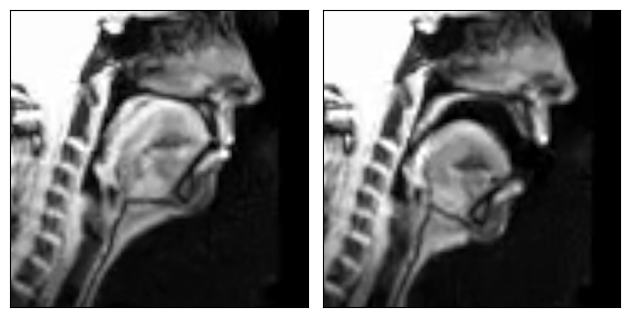

In [2]:
path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/Participant_12/Processed_data/Video/Subject_12_01.mp4"
from torchvision.io import read_video
import av
frames, _, _ = read_video(str(path), output_format="TCHW") # returns video frames, audio frames, metadata for the video and audio

img1_batch = torch.stack([frames[53, :, 100:600, 500:1000], frames[84, :, 100:600, 500:1000]]) # making predictions between 2 pairs of frames 53 and 83, and 84 and 130
img2_batch = torch.stack([frames[83, :, 100:600, 500:1000], frames[130, :, 100:600:, 500:1000]])
# img1_batch = frames[53, :, 100:600, 500:1000]
# img2_batch = frames[84, :, 100:600, 500:1000]
# 150:500, 600:900 smaller concentrated image
# 100:600, 500:1000 slightly bigger
plot(img1_batch)

In [163]:
def preprocess(img1_batch, img2_batch):
    # img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    # img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    weights = Raft_Large_Weights.DEFAULT
    transforms = weights.transforms()
    img1_batch = F.resize(img1_batch, size=[352, 352], antialias=False) # resize frames to ensure they are divisable by 8 
    img2_batch = F.resize(img2_batch, size=[352, 352], antialias=False)
    return transforms(img1_batch, img2_batch)


from torchvision.models.optical_flow import Raft_Large_Weights
from torchvision.models.optical_flow import raft_large

def raft_(img1_batch, img2_batch, raft_ = 'large', device = 'cpu'):
    # set the weights
    weights = Raft_Large_Weights.DEFAULT
    transforms = weights.transforms()
    # prepare the images for the model
    img1_batch, img2_batch = preprocess(img1_batch, img2_batch)
    # create model
    model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
    model = model.eval()

    # get list of predictions
    list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
    # get the last one - most accurate
    predicted_flow = list_of_flows[-1]

    return predicted_flow

In [3]:
from raft_functions import *

In [4]:
# from raft_functions import raft
predicted_flow1 = raft(img1_batch, img2_batch)

In [8]:
def evaluate_raft_(img1_batch, img2_batch, predicted_flows, remapping = 'forward'):
    images1 = convert_images(img1_batch) # all frames 1
    images2 = convert_images(img2_batch) # all frames 2

    flows = convert_flow(predicted_flows)
    similarity = []
    mapped = []
    if remapping == 'forward':
        for i in range(len(flows)):
            mapped.append(remap_forward(images1[i], flows[i]))
            print(mapped[i].shape)
            print(images2[i].shape)
            similarity.append([sm.structural_similarity(images2[i][: , :, 0], mapped[i][:, :, 0]  )])
        
    else:
        for i in range(len(flows)):
            mapped.append(remap_backward(images2[i], flows[i]))
            print(mapped[i].shape)
            print(images2[i].shape)
            similarity.append([sm.structural_similarity(images1[i][: , :, 0], mapped[i][:, :, 0]  )])
    

    return similarity

In [10]:
# from raft_functions import evaluate_raft

evaluation = evaluate_raft_(img1_batch, img2_batch, predicted_flow1, 'backward')
print(evaluation)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [87]:
from torchvision.io import read_video_timestamps
stamps = read_video_timestamps(str(path), 'sec')

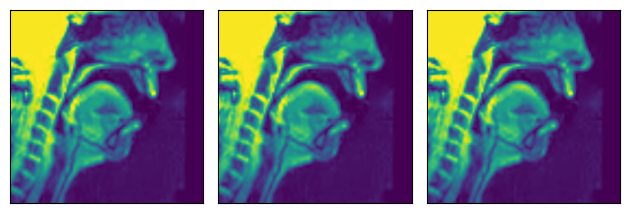

In [ ]:
plot(img2_batch)

The RAFT model accepts RGB images. We first get the frames from
:func:`~torchvision.io.read_video` and resize them to ensure their dimensions
are divisible by 8. Note that we explicitly use ``antialias=False``, because
this is how those models were trained. Then we use the transforms bundled into
the weights in order to preprocess the input and rescale its values to the
required ``[-1, 1]`` interval.



In [105]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    # img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    # img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    img1_batch = F.resize(img1_batch, size=[352, 352], antialias=False) # resize frames to ensure they are divisable by 8 
    img2_batch = F.resize(img2_batch, size=[352, 352], antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 352, 352]), dtype = torch.float32


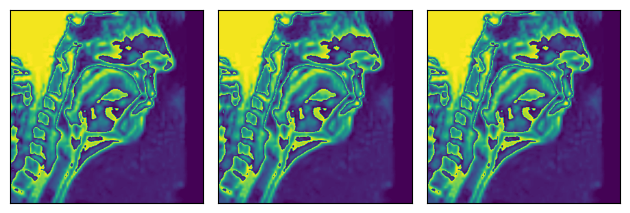

In [ ]:
plot(img1_batch)

In [ ]:
print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 352, 352]), dtype = torch.float32


## Estimating Optical flow using RAFT
We will use our RAFT implementation from
:func:`~torchvision.models.optical_flow.raft_large`, which follows the same
architecture as the one described in the [original paper](https://arxiv.org/abs/2003.12039).
We also provide the :func:`~torchvision.models.optical_flow.raft_small` model
builder, which is smaller and faster to run, sacrificing a bit of accuracy.



In [5]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device =  "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


In [ ]:
device

'cpu'

The RAFT model outputs lists of predicted flows where each entry is a
(N, 2, H, W) batch of predicted flows that corresponds to a given "iteration"
in the model. For more details on the iterative nature of the model, please
refer to the [original paper](https://arxiv.org/abs/2003.12039). Here, we
are only interested in the final predicted flows (they are the most acccurate
ones), so we will just retrieve the last item in the list.

As described above, a flow is a tensor with dimensions (2, H, W) (or (N, 2, H,
W) for batches of flows) where each entry corresponds to the horizontal and
vertical displacement of each pixel from the first image to the second image.
Note that the predicted flows are in "pixel" unit, they are not normalized
w.r.t. the dimensions of the images.



In [6]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 352, 352]) = (N, 2, H, W)
min = -27.04751968383789, max = 43.16575241088867


## Visualizing predicted flows
Torchvision provides the :func:`~torchvision.utils.flow_to_image` utlity to
convert a flow into an RGB image. It also supports batches of flows.
each "direction" in the flow will be mapped to a given RGB color. In the
images below, pixels with similar colors are assumed by the model to be moving
in similar directions. The model is properly able to predict the movement of
the ball and the player. Note in particular the different predicted direction
of the ball in the first image (going to the left) and in the second image
(going up).



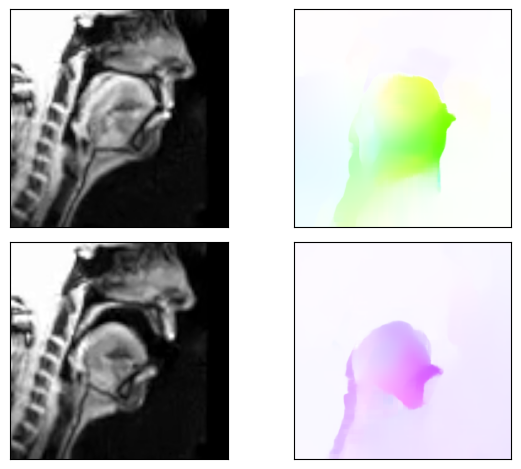

In [7]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img_batch, flow_imgs)]
plot(grid)

Converting torch predicted flows to numpy flows

In [8]:
def convert_flow(predicted_flows):
    flows_tchw = [predicted_flows[a].detach().numpy()[:,:,:] for a in range(predicted_flows.shape[0])] # make it back to numpy arrays for all N predicted flows
    flows = np.moveaxis(flows_tchw, 0, -1) # change the dimmensions from TCHW to THWC
    return flows

# flow1 =predicted_flows
# print(predicted_flows.shape)
# flow1 = flow1.detach().numpy()[:, :,:,:]
# flows = np.moveaxis(flow1, 0, -1)
flows = convert_flow(predicted_flows)
print(flows.shape) # N H T 2

(2, 352, 352, 2)


Converting torch image to numpy image

(2, 352, 352, 3)


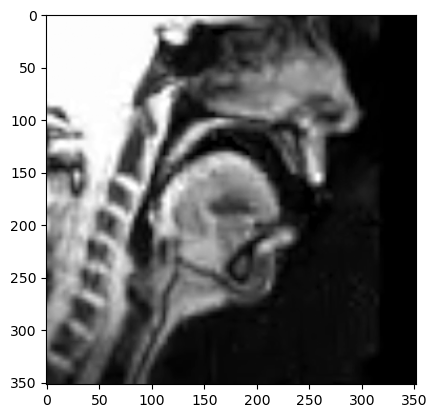

In [9]:
def convert_images(img_batch):
    # print(img_batch.shape)
    img2_batch = [(img2 + 1) / 2 for img2 in img_batch] # upsampling the image back to original
    # print(len(img2_batch))
    img2 = np.array([np.moveaxis(img2_batch[a].numpy()[:,:,:], 0, -1) for a in range(len(img2_batch))])
    return img2

images1 = convert_images(img1_batch) # all frames 1
images2 = convert_images(img2_batch) # all frames 2

# print(convert_torch(img1_batch))
print(images1.shape)
plt.imshow(images2[0])

Drawing optical flow on top of the image

In [10]:
import cv2
def draw_flow(img, flow, step=16):
        h, w = img.shape[:2]
        y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
        fx, fy = flow[y,x].T
        lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
        lines = np.int32(lines + 0.5)
        vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.polylines(vis, lines, 0, (0, 255, 0))
        for (x1, y1), (_x2, _y2) in lines:
            cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
        return vis

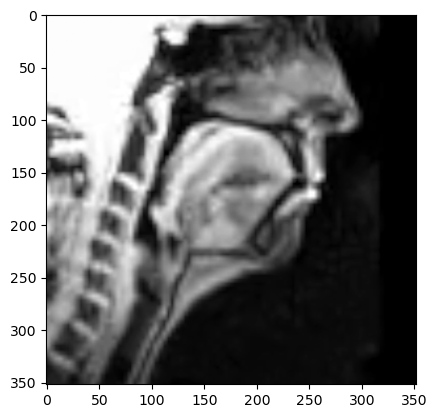

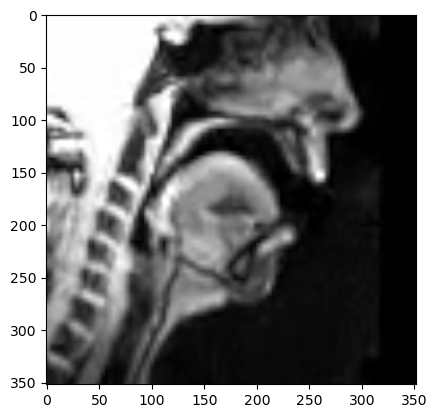

In [11]:
for i in range(images1.shape[0]):
    plt.imshow(images1[i])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


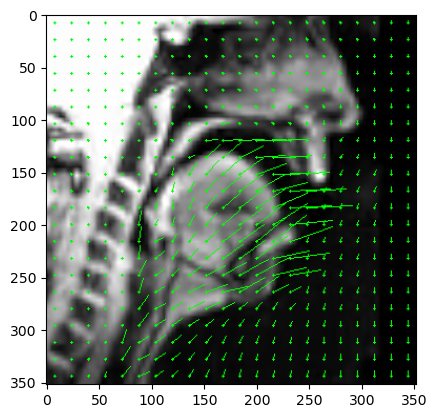

In [12]:
plt.imshow(draw_flow(images1[1, :, :, 0], flows[1,  : , : , :]))

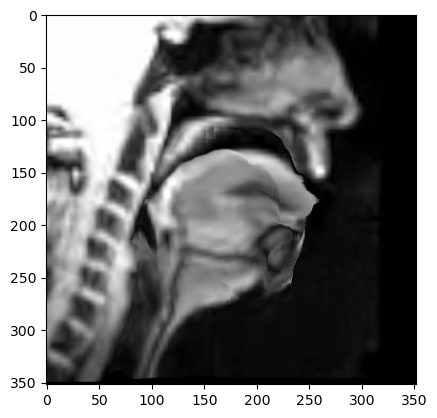

Second image warped into the first: 0.8115488783089698


In [78]:
x = np.linspace(0, images1[1].shape[1], images1[1].shape[1])
y = np.linspace(0, images1[1].shape[0], images1[1].shape[0])
xv, yv = np.meshgrid(x,y)
map_x = -flows[1, :, :, 0] + xv
map_y = -flows[1, :, :, 1] + yv

map_x = map_x.astype(np.float32)

map_y.astype(np.float32)
type(map_x.astype(np.float32))

mapped_img = cv2.remap(images1[1], map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
plt.imshow(mapped_img, cmap = "gray")
plt.show()
# print(mapped_img)

from skimage import metrics as sm

print('First image warped into the second:', sm.structural_similarity(images2[1, :, :, 0], mapped_img[:,:,0]))

In [92]:
remapping = 'forward'
print(remapping)

forward


In [59]:
def remap_forward(image, flow):
    flow[np.isnan(flow)] = 0
    x = np.linspace(0, image.shape[0], image.shape[0])
    y = np.linspace(0, image.shape[1], image.shape[1])
    xv, yv = np.meshgrid(x,y)
    map_x = -flow[:, :, 0] + xv
    map_y = -flow[:, :, 1] + yv

    mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
    return mapped_img

In [74]:
def remap_backward(image, flow):
    flow[np.isnan(flow)] = 0
    x = np.linspace(0, image.shape[0], image.shape[0])
    y = np.linspace(0, image.shape[1], image.shape[1])
    xv, yv = np.meshgrid(x,y)
    map_x = flow[:, :, 0] + xv
    map_y = flow[:, :, 1] + yv

    mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
    return mapped_img

In [66]:
def draw_process_evaluate(image1, image2, mapped):
    plt.subplot(1,3,1)
    plt.imshow(image1)
    plt.subplot(1,3,2)
    plt.imshow(image2)
    plt.subplot(1,3,3)
    plt.imshow(mapped, cmap = "gray")
    plt.show()
    print('Structural similarity between the 2 images:', sm.structural_similarity(image2[:, :, 0], mapped[:,:,0]))

In [61]:
def draw_remap_with_flow(image, image2, flow):
    flow[np.isnan(flow)] = 0
    x = np.linspace(0, image.shape[0], image.shape[0])
    y = np.linspace(0, image.shape[1], image.shape[1])
    xv, yv = np.meshgrid(x,y)
    map_x = flow[:, :, 0] + xv
    map_y = flow[:, :, 1] + yv

    mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(image2)
    plt.subplot(1,3,3)
    plt.imshow(mapped_img, cmap = "gray")
    plt.show()

    from skimage import metrics as sm

    print('Second image warped into the first:', sm.structural_similarity(image2[:, :, 0], mapped_img[:,:,0]))


First image warped into the second: 0.8115488783089698


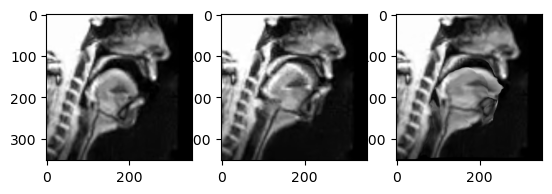

Structural similarity between the 2 images: 0.8115488783089698


In [67]:
mapped = remap_forward(images1[1], flows[1])
print('First image warped into the second:', sm.structural_similarity(images2[1, :, :, 0], mapped[:,:,0]))
draw_process_evaluate(images1[1], images2[1], mapped)

First image warped into the second: 0.8006483130561738


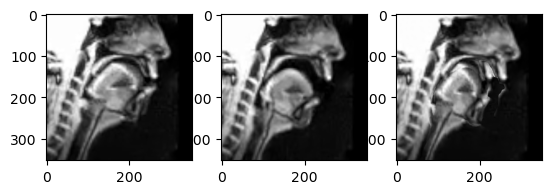

Structural similarity between the 2 images: 0.8006483130561738


In [75]:
mapped = remap_backward(images2[1], flows[1])
print('First image warped into the second:', sm.structural_similarity(images1[1, :, :, 0], mapped[:,:,0]))
draw_process_evaluate(images2[1], images1[1], mapped)


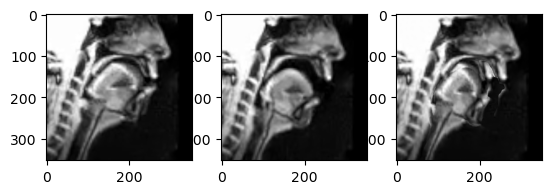

Second image warped into the first: 0.8006483130561738


In [79]:
draw_remap_with_flow(images2[1], images1[1], flows[1])

In [ ]:
import flowpy
predicted_flows[np.isnan(predicted_flows)] = 0
warped_second_image = flowpy.forward_warp(img1_batch, predicted_flows)

fig, ax = plt.subplots()

ax.imshow(warped_second_image, cmap = 'gray')
ax.set_title( "First image warped to the second")
ax.set_axis_off()

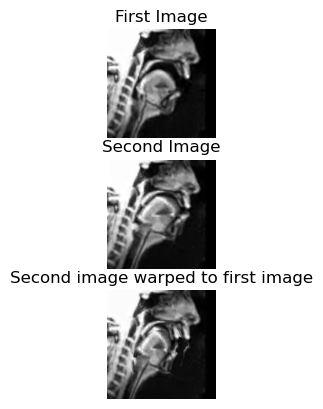

Second image warped into the first: 0.8023175209211169


In [34]:
import flowpy

flows[1][np.isnan(flows[1])] = 0
warped_first_image = flowpy.backward_warp(images2[1], flows[1])

fig, axes = plt.subplots(3, 1)
# fig, ax = plt.subplots(2, 2, figsize=(10,7))
for ax, image, title in zip(axes, (images1[1, :,:,0], images2[1, :,:,0], warped_first_image[:,:, 0]),
                            ("First Image", "Second Image", "Second image warped to first image")):
    ax.imshow(image, cmap = 'gray')
    ax.set_title(title)
    ax.set_axis_off()

plt.show()
print('Second image warped into the first:', sm.structural_similarity(images1[1, :, :, 0], warped_first_image[:,:,0]))

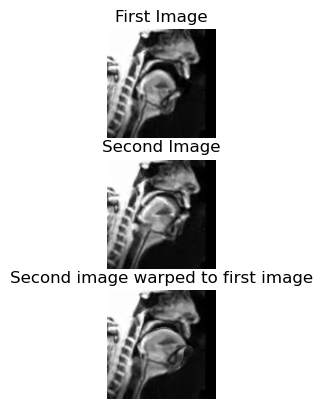

First image warped into the second: 0.8175551770007009


In [39]:
import flowpy

flows[1][np.isnan(flows[1])] = 0
warped_first_image = flowpy.forward_warp(images1[1], flows[1])

fig, axes = plt.subplots(3, 1)
# fig, ax = plt.subplots(2, 2, figsize=(10,7))
for ax, image, title in zip(axes, (images1[1, :,:,0], images2[1, :,:,0], warped_first_image[:,:, 0]),
                            ("First Image", "Second Image", "Second image warped to first image")):
    ax.imshow(image, cmap = 'gray')
    ax.set_title(title)
    ax.set_axis_off()

plt.show()
print('First image warped into the second:', sm.structural_similarity(images2[1, :, :, 0], warped_first_image[:,:,0]))

## Bonus: Creating GIFs of predicted flows
In the example above we have only shown the predicted flows of 2 pairs of
frames. A fun way to apply the Optical Flow models is to run the model on an
entire video, and create a new video from all the predicted flows. Below is a
snippet that can get you started with this. We comment out the code, because
this example is being rendered on a machine without a GPU, and it would take
too long to run it.



In [ ]:
device = 'cpu'
print(device)

cpu


In [ ]:
from torchvision.io import write_jpeg
for i, (img1, img2) in enumerate(zip(frames[40:80], frames[41:81])):
    # Note: it would be faster to predict batches of flows instead of individual flows
    img1_batch = torch.stack([img1[ :, 100:600, 500:1000], img1[:, 100:600, 500:1000]])
    img2_batch = torch.stack([img2[ :, 100:600, 500:1000], img2[:, 100:600, 500:1000]])
    img1, img2 = preprocess(img1_batch, img2_batch)

    list_of_flows = model(img1.to(device), img2.to(device))
    predicted_flow = list_of_flows[-1][0]
    flow_img = flow_to_image(predicted_flow).to("cpu")
    output_folder = "C:/Users/Misha/OneDrive - University of Sussex/FYP"  # Update this to the folder of your choice
    write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")

Once the .jpg flow images are saved, you can convert them into a video or a
GIF using ffmpeg with e.g.:

ffmpeg -f image2 -framerate 30 -i predicted_flow_%d.jpg -loop -1 flow.gif



In [ ]:
# (
#     ffmpeg
#     .input('/path/to/jpegs/*.jpg', pattern_type='glob', framerate=25)
#     .output('movie.mp4')
#     .run()
# )